R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Transformations_WLS.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)


# Transformations & Weighted Least Squares


-   We have been working with *linear* regression models so far in the
    course.

-   Some models are nonlinear, but can be *transformed* to a linear
    model.
    
-   We will also see that transformations can sometimes *stabilize* the variance
    making constant variance a more reasonable assumption.

-   Finally, we will see how to correct for unequal variance using a technique weighted least squares (WLS).



In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import interaction_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.api import abline_plot
from statsmodels.graphics.gofplots import qqplot

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'


## Bacterial colony decay

Here is a simple dataset showing the number of bacteria alive in a colony, $N_t$
as a function of time $t$. A simple linear regression model is clearly not a very
good fit.

In [4]:
url = "http://stats191.stanford.edu/data/bacteria.table"
bacteria_data = pd.read_table(url)
bacteria_data.head()
bacteria_res = ols("N_t ~ t", data=bacteria_data).fit()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


In [5]:
def plot_abline_scatter(data, result):
    fig = abline_plot(model_results = result, color='red')
    ax = fig.axes[0]
    ax.scatter(data.t, data.N_t, color ='orange', marker='D')
    plt.xlabel("Time, t")
    plt.ylabel("The number of bacteria alive in a colony, N_t")
    plt.show()

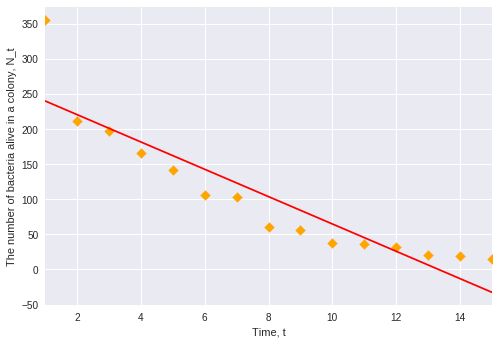

In [6]:
plot_abline_scatter(data=bacteria_data, result=bacteria_res)

In [7]:
# Residuals vs. Fitted
def residuals_fitted(data, y, result, ax):
    sns.residplot(result.fittedvalues, y, 
                  data=data, 
                  lowess=True,
                  scatter_kws={'alpha': 0.5},
                  line_kws={'color': 'red', 'alpha':0.5},
                  ax=ax)
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs. Fitted')
    return ax

In [8]:
# Normal Q-Q Plot
def normal_qq_plot(result, ax):
    # result.resid also works too
#     fig = qqplot(result.resid, line='q', alpha=0.5, ax=ax)
    # standardized residuals
    fig = qqplot(result.get_influence().resid_studentized_internal, line='q', alpha=0.5, ax=ax)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized residuals')
    ax.set_title('Normal Q-Q')
    return fig

In [9]:
# Scale-location
def scale_location(result, ax):
    norm_resid = result.get_influence().resid_studentized_internal
    abs_sqrt_norm_resid = np.sqrt(np.abs(norm_resid))
    ax.scatter(result.fittedvalues, abs_sqrt_norm_resid, alpha=0.5)
    sns.regplot(result.fittedvalues, abs_sqrt_norm_resid, 
                scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'alpha':0.5},
                ax=ax)
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('np.sqrt(standardized residuals)')
    ax.set_title('Scale-location')
    return ax

In [10]:
# Residuals vs. Leverage
def residuals_leverage(result, ax, xmin=0, xmax=0.3, ymin=-1, ymax=5): 
    norm_resid = result.get_influence().resid_studentized_internal
    leverage = result.get_influence().hat_matrix_diag
    ax.scatter(leverage, norm_resid, alpha=0.5)
    sns.regplot(leverage, norm_resid, 
                scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'alpha':0.5},
                ax=ax)
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')
    ax.set_title('Residuals vs. Leverage')

    x = np.linspace(0, 0.3, 50)
    y = np.sqrt((0.5 * len(result.params) * (1 - x)) / x)
    ax.plot(x, y, label='Cook\'s distance', ls='--', color='red')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    return ax

In [11]:
def make_plots(data, y, result, xmin=0, xmax=0.3, ymin=-1, ymax=5):
    fig, axes = plt.subplots(2,2, sharex=False, sharey=False)
    axes[0, 0] = residuals_fitted(data=data, y=y,
                                  result=result, 
                                  ax=axes[0, 0])
    axes[0, 1] = normal_qq_plot(result=result,
                                 ax=axes[0, 1])
    axes[1, 0] = scale_location(result=result,
                                 ax=axes[1, 0])
    axes[1, 1] = residuals_leverage(result=result,
                                 ax=axes[1, 1],
                                 xmin=xmin, xmax=xmax,
                                 ymin=ymin, ymax=ymax)
    plt.tight_layout()
    plt.show()

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


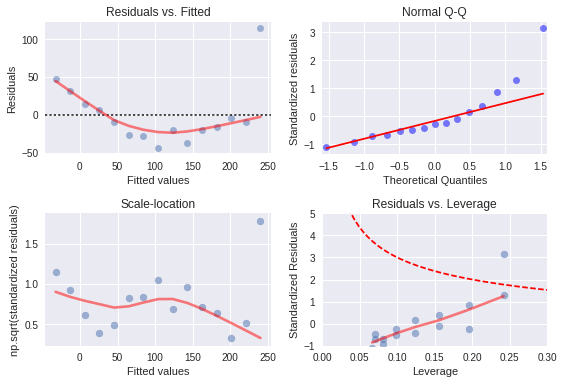

In [12]:
make_plots(data=bacteria_data, y='N_t', result=bacteria_res)

## Exponential decay model

-   Suppose the expected number of cells grows like
    $$E(n_t) = n_0 e^{\beta_1t}, \qquad t=1, 2, 3, \dots$$

-   If we take logs of both sides
    $$\log E(n_t) = \log n_0 + \beta_1 t.$$

-   A reasonable (?) model:
    $$\log n_t = \log n_0 + \beta_1 t + \varepsilon_t, \qquad \varepsilon_t \overset{IID}{\sim} N(0,\sigma^2).$$


In [13]:
# 1. directly modifying the data
bacteria_log_data = bacteria_data.copy()
bacteria_log_data["log_N_t"] = np.log(bacteria_data["N_t"])
print(bacteria_log_data.head())
bacteria_log_res = ols("log_N_t ~ t", data=bacteria_log_data).fit()
bacteria_log_res.params

   t  N_t   log_N_t
0  1  355  5.872118
1  2  211  5.351858
2  3  197  5.283204
3  4  166  5.111988
4  5  142  4.955827


Intercept    5.973160
t           -0.218425
dtype: float64

In [14]:
# 2. using statsmodels R-style formula
bacteria_log_res = ols("np.log(N_t) ~ t", data=bacteria_log_data).fit()
bacteria_log_res.params

Intercept    5.973160
t           -0.218425
dtype: float64

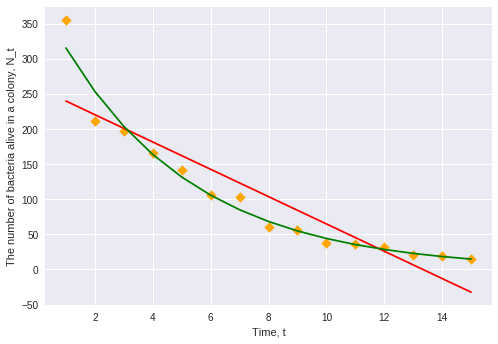

In [15]:
plt.scatter(bacteria_log_data.t, bacteria_log_data.N_t, 
            color ='orange', marker='D')
plt.plot(bacteria_log_data.t, bacteria_res.fittedvalues,
        color='red')
plt.plot(bacteria_log_data.t, np.exp(bacteria_log_res.fittedvalues),
        color='green')
plt.xlabel("Time, t")
plt.ylabel("The number of bacteria alive in a colony, N_t")
plt.show()

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


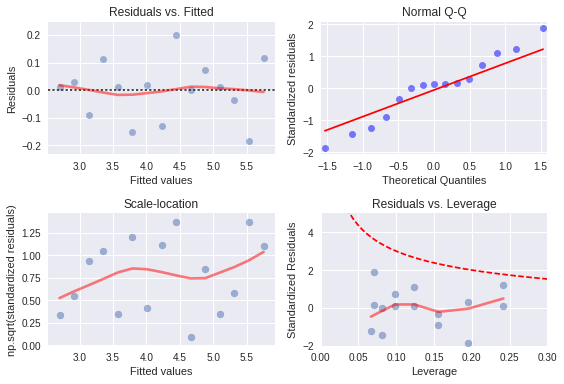

In [16]:
make_plots(data=bacteria_log_data, y='log_N_t', result=bacteria_log_res, ymin=-2)

### Logarithmic transformation

-   This model slightly different than original model:
    $$E(\log n_t) \leq \log E(n_t)$$ but may be approximately true.

-   If $\varepsilon_t \sim N(0,\sigma^2)$ then
    $$n_t = n_0 \cdot \gamma_t \cdot e^{\beta_1 t}.$$

-   $\gamma_t=e^{\varepsilon_t}$ is called a log-normal 
    $(0,\sigma^2)$ random variable.

## Linearizing regression function

We see that an exponential growth or decay model can
be made (approximately) linear. Here are a few other models that can be linearized:

-   $y=\alpha x^{\beta}$, use $\tilde{y}=\log(y), \tilde{x}=\log(x)$;

-   $y=\alpha e^{\beta x}$, use $\tilde{y}=\log(y)$;

-   $y=x/(\alpha x - \beta)$, use $\tilde{y}=1/y, \tilde{x}=1/x$.

-   More in textbook.

### Caveats

-   Just because expected value linearizes, does not mean that the errors
    behave correctly.

-   In some cases, this can be corrected using weighted least squares
    (more later).

-   Constant variance, normality assumptions should still be checked.

## Stabilizing variance

-   Sometimes, a transformation can turn non-constant variance errors to
    "close to" constant variance. This is another situation in which we might
    consider a transformation.

-   Example: by the "delta rule", if
    $$\text{Var}(Y) = \sigma^2 E(Y)$$ then
    $$\text{Var}(\sqrt{Y}) \simeq \frac{\sigma^2}{4}.$$
    
-   In practice, we might not know which transformation is best. [Box-Cox transformations](http://en.wikipedia.org/wiki/Power_transform) offer a tool to find a "best" transformation.

## Delta rule

The following approximation is ubiquitous in statistics.

-   Taylor series expansion:
    $$f(Y) = f(E(Y)) + \dot{f}(E(Y)) (Y - E(Y)) + \dots$$

-   Taking expectations of both sides yields:
    $$\text{Var}(f(Y)) \simeq \dot{f}(E(Y))^2  \cdot \text{Var}(Y)$$

## Delta rule

-  So, for our previous example:
    $$\text{Var}(\sqrt{Y}) \simeq \frac{\text{Var}(Y)}{4 \cdot E(Y)}$$
    
- Another example
    $$\text{Var}(\log(Y)) \simeq \frac{\text{Var}(Y)}{E(Y)^2}.$$

### Caveats

-   Just because a transformation makes variance constant does not mean
    regression function is still linear (or even that it was linear)!

-   The models are approximations, and once a model is selected our
    standard diagnostics should be used to assess adequacy of fit.

-   It is possible to have non-constant variance but the variance
    stabilizing transformation may destroy linearity of the regression
    function. 
    
    - *Solution:* try weighted least squares (WLS).

## Correcting for unequal variance: weighted least squares

- We will now see an example in which there seems to be strong evidence
for variance that changes based on `Region`.

- After observing this, we will create a new model that
attempts to *correct* for this and come up with better estimates.

- *Correcting* for unequal variance, as we describe it here, generally
requires a model for how the variance depends on observable quantities.

## Correcting for unequal variance: weighted least squares



<table>
<tr><td><b>Variable</b></td><td><b>Description</b></td></tr>
<tr><td>$Y$</td><td>Per capita education expenditure by state</td></tr>
<tr><td>$X_1$</td><td>Per capita income in 1973 by state</td></tr>
<tr><td>$X_2$</td><td>Proportion of population under 18</td></tr>
<tr><td>$X_3$</td><td>Proportion in urban areas</td></tr>
<tr><td>`Region`</td><td>Which region of the country are the states located in</td></tr>
</table>

In [17]:
url = "http://stats191.stanford.edu/data/education1975.table"
education_data = pd.read_table(url)
education_data.head(6)

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,STATE,Y,X1,X2,X3,Region
0,ME,235,3944,325,508,1
1,NH,231,4578,323,564,1
2,VT,270,4011,328,322,1
3,MA,261,5233,305,846,1
4,RI,300,4780,303,871,1
5,CT,317,5889,307,774,1


In [18]:
education_data.columns

Index(['STATE ', 'Y ', 'X1 ', 'X2 ', 'X3 ', 'Region  '], dtype='object')

In [19]:
education_data.rename(columns={"STATE ":"STATE",
                               "Y ":"Y",
                               "X1 ":"X1",
                               "X2 ":"X2",
                               "X3 ":"X3",
                               "Region  ": "Region" 
                               }, inplace=True)

In [20]:
education_data.columns

Index(['STATE', 'Y', 'X1', 'X2', 'X3', 'Region'], dtype='object')

In [21]:
region_factor = pd.Categorical(education_data["Region"])
region_factor

[1, 1, 1, 1, 1, ..., 4, 4, 4, 4, 4]
Length: 50
Categories (4, int64): [1, 2, 3, 4]

In [22]:
formula = "Y ~ X1 + X2 + X3"
education_res = ols(formula, data=education_data).fit()
education_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     22.19
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           4.94e-09
Time:                        01:10:22   Log-Likelihood:                -253.89
No. Observations:                  50   AIC:                             515.8
Df Residuals:                      46   BIC:                             523.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -556.5680    123.195     -4.518      0.000    -804.547    -308.589
X1             0.0724      0.012      6.239      0.000       0.049       0.096
X2             1.5521      0.315      4.932      0.000       0.919       2.185
X3            -0.0043      0.051     -0.083      0.934      -0.108       0.099
==============================================================================
Omnibus:                        0.719   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.760
Skew:                           0.264   Prob(JB):                        0.684
Kurtosis:                       2.705   Cond. No.                     1.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


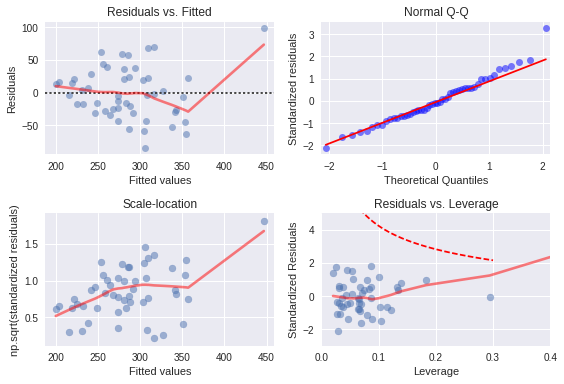

In [23]:
make_plots(data=education_data, y='Y', result=education_res, xmax=0.4, ymin=-3)

In [24]:
infl = education_res.get_influence()
infl.resid_studentized_internal # rstandard()

array([ 0.09733303, -1.07301386,  0.76018334, -0.79193686,  1.14704983,
       -0.67490698,  1.81309575, -1.36259063,  1.01086908, -2.12890654,
       -1.06569626, -1.15801331,  0.56245933,  1.41982951,  1.72815395,
       -1.39132237, -0.68545913, -1.52817152, -0.88712399, -0.39573961,
        1.48644887, -0.16464353,  0.06661636, -0.32649885,  0.3717291 ,
        0.18083548, -0.39607097, -0.60696202,  0.56228922, -0.42519984,
       -0.08815936, -0.45566118, -0.83714672,  0.43003158, -0.64252595,
        0.39336951, -0.1249304 ,  0.53154057, -0.50430088,  0.50266845,
       -0.1057826 ,  0.9850654 ,  0.98474018, -0.04644862, -1.62959705,
        0.6211206 ,  1.56928622,  0.57734117,  3.2823873 , -0.76660817])

In [25]:
education_data["rstandard"] = infl.resid_studentized_internal

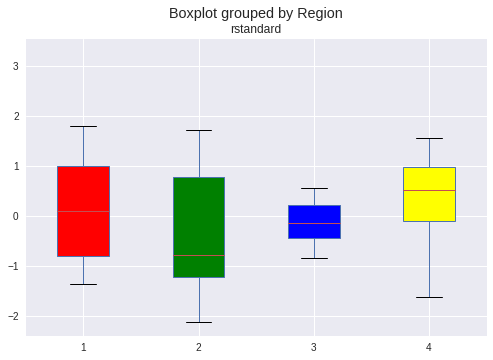

In [26]:
# to fill the colors inside the box
bp_dict = education_data.boxplot("rstandard",
    by="Region", 
    return_type='both',
    patch_artist = True,
)

colors = ['red', 'green', 'blue', 'yellow']
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.show()

In [27]:
education_data["STATE"] = education_data["STATE"].apply(lambda x: x.strip())

In [28]:
sorted(education_data.STATE.unique())[:5]

['AK', 'AL', 'AR', 'AZ', 'CA']

In [29]:
# 1. directly modifying the data
education_data_noAK = education_data[education_data["STATE"]!="AK"]
sorted(education_data_noAK.STATE.unique())[:5]

['AL', 'AR', 'AZ', 'CA', 'CO']

In [30]:
education_res_noAK = ols("Y ~ X1 + X2 + X3", data=education_data_noAK).fit()
education_res_noAK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     14.80
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.65e-07
Time:                        01:10:23   Log-Likelihood:                -242.77
No. Observations:                  49   AIC:                             493.5
Df Residuals:                      45   BIC:                             501.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -277.5773    132.423     -2.096      0.042    -544.291     -10.864
X1             0.0483      0.012      3.976      0.000       0.024       0.073
X2             0.8869      0.331      2.678      0.010       0.220       1.554
X3             0.0668      0.049      1.354      0.183      -0.033       0.166
==============================================================================
Omnibus:                        0.883   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.932
Skew:                           0.289   Prob(JB):                        0.628
Kurtosis:                       2.652   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
idx = education_data.index[education_data["STATE"]!="AK"]
idx

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49],
           dtype='int64')

In [32]:
# 2. using statsmodels R-style formula
education_res_noAK = ols("Y ~ X1 + X2 + X3", 
                         data=education_data_noAK,
                         subset=idx).fit()
education_res_noAK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     14.80
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.65e-07
Time:                        01:10:23   Log-Likelihood:                -242.77
No. Observations:                  49   AIC:                             493.5
Df Residuals:                      45   BIC:                             501.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -277.5773    132.423     -2.096      0.042    -544.291     -10.864
X1             0.0483      0.012      3.976      0.000       0.024       0.073
X2             0.8869      0.331      2.678      0.010       0.220       1.554
X3             0.0668      0.049      1.354      0.183      -0.033       0.166
==============================================================================
Omnibus:                        0.883   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.932
Skew:                           0.289   Prob(JB):                        0.628
Kurtosis:                       2.652   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


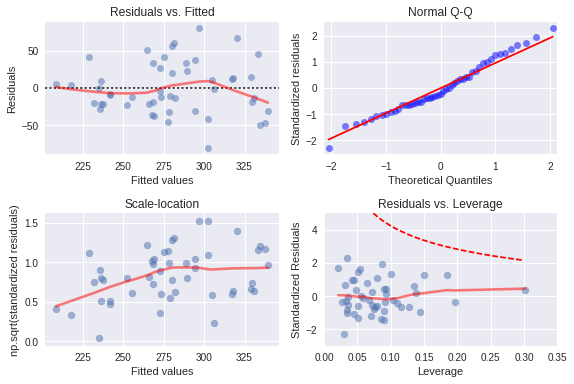

In [33]:
make_plots(data=education_data_noAK, y='Y', result=education_res_noAK, xmax=0.35, ymin=-3)

In [34]:
infl_noAK = education_res_noAK.get_influence()
infl_noAK.resid_studentized_internal # rstandard()

array([-2.11246222e-03, -1.04185722e+00,  1.25525621e+00, -1.19262235e+00,
        5.94918815e-01, -4.08731307e-01,  1.95686704e+00, -1.45935011e+00,
        7.91043780e-01, -2.30082754e+00, -8.69584585e-01, -9.22032944e-01,
        1.34616244e+00,  1.71795907e+00,  2.29871857e+00, -1.31340533e+00,
       -1.08373978e+00, -9.74679259e-01, -6.49782154e-01, -3.02553865e-01,
        1.62481240e+00,  4.36628687e-01,  3.57313025e-01, -3.51803711e-01,
        1.71799056e-01,  2.56476260e-01, -2.56873547e-01, -5.19989683e-01,
       -3.78640949e-01, -6.07510919e-01, -5.71696364e-01, -8.05589163e-01,
       -6.33454374e-01,  1.06852133e-01, -6.57764075e-01, -2.22459616e-01,
       -3.86010425e-01,  9.55601811e-01, -1.27548150e-01,  9.74597482e-01,
       -5.42655371e-02,  1.28549428e+00,  1.08678026e+00,  3.41051713e-01,
       -1.36271320e+00,  6.39651627e-01,  1.47431461e+00,  4.08642755e-01,
       -5.40923879e-01])

In [35]:
education_data_noAK["rstandard"] = infl_noAK.resid_studentized_internal

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


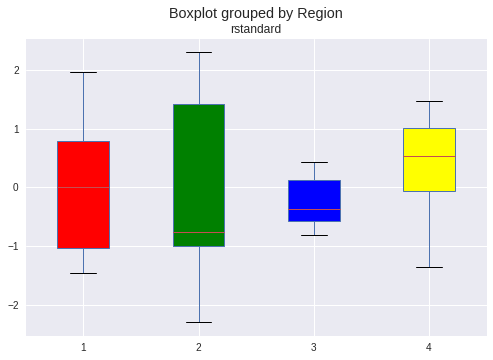

In [36]:
# to fill the colors inside the box
bp_dict = education_data_noAK.boxplot("rstandard",
    by="Region", 
    return_type='both',
    patch_artist = True,
)

colors = ['red', 'green', 'blue', 'yellow']
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.show()

## Reweighting observations

-   If you have a reasonable guess of variance as a function of the
    predictors, you can use this to *reweight* the data.

-   Hypothetical example
    $$Y_i = \beta_0 + \beta_1 X_i + \varepsilon_i, \qquad \varepsilon_i \sim N(0,\sigma^2 X_i^2).$$

-   Setting $\tilde{Y}_i = Y_i / X_i$, $\tilde{X}_i = 1 / X_i$, model
    becomes
    $$\tilde{Y}_i = \beta_0 \tilde{X}_i + \beta_1 + \gamma_i, \gamma_i \sim N(0,\sigma^2).$$

## Weighted Least Squares

-   Fitting this model is equivalent to minimizing
    $$\sum_{i=1}^n \frac{1}{X_i^2} \left(Y_i - \beta_0 - \beta_1 X_i\right)^2$$

-   Weighted Least Squares
    $$SSE(\beta, w) = \sum_{i=1}^n w_i \left(Y_i - \beta_0 - \beta_1 X_i\right)^2, \qquad w_i = \frac{1}{X_i^2}.$$

-   In general, weights should be like:
    $$w_i = \frac{1}{\text{Var}(\varepsilon_i)}.$$
    
- Our education expenditure example assumes
    $$
    w_i = W_{\tt Region[i]}
    $$

## What if we didn't reweight?

- Our (ordinary) least squares estimator  with design matrix $X$ is
$$
\hat{\beta} =\hat{\beta}_{OLS} =  (X^TX)^{-1}X^TY = \beta + (X^TX)^{-1}X^T\epsilon.
$$

- Our model says that $\varepsilon | X \sim N(0, \sigma^2X)$ so
$$
\begin{aligned}
E[(X^TX)^{-1}X^T\epsilon] &= E[(X^TX)^{-1}X^T\epsilon|X] \\
&= 0
\end{aligned}
$$
So the **OLS estimator is unbiased.**

- Variance of $\hat{\beta}_{OLS}$ is
$$
\text{Var}((X^TX)^{-1}X^T\epsilon) = \sigma^2 (X^TX)^{-1}X^TVX (X^TX)^{-1}, \qquad V =\text{diag}(X_1^2, \dots, X_n^2)
$$

## Common weighting schemes

-   If you have a qualitative variable, then it is easy to estimate
    weight within groups (our example today).

-   "Often" $$\text{Var}(\varepsilon_i) = \text{Var}(Y_i) = V(E(Y_i))$$

-   Many non-Gaussian (non-Normal) models behave like this: logistic, Poisson
    regression.

## Two stage procedure

-   Suppose we have a hypothesis about the weights, i.e. they are
    constant within Region, or they are something like
    $$w_i^{-1} = \text{Var}(\epsilon_i) =  \alpha_0 + \alpha_1 X_{i1}^2.$$

-   We pre-whiten:

    1.  Fit model using OLS (Ordinary Least Squares) to get initial
        estimate $\widehat{\beta}_{OLS}$

    2.  Use predicted values from this model to estimate $w_i$.

    3.  Refit model using WLS (Weighted Least Squares).

    4.  If needed, iterate previous two steps.

In [37]:
education_data["weights"] = np.zeros(education_data.Y.shape)

In [38]:
education_data.head()

,STATE,Y,X1,X2,X3,Region,rstandard,weights
0,ME,235,3944,325,508,1,0.097333,0.0
1,NH,231,4578,323,564,1,-1.073014,0.0
2,VT,270,4011,328,322,1,0.760183,0.0
3,MA,261,5233,305,846,1,-0.791937,0.0
4,RI,300,4780,303,871,1,1.147050,0.0


In [39]:
weights = []
for region, group in education_data_noAK.groupby("Region"):
    print("\nRegion: ", region)
    print(group.index)
    print(np.sum(education_res_noAK.resid[group.index]**2)/group.shape[0])
    weight = 1/(np.sum(education_res_noAK.resid[group.index]**2)/group.shape[0]) 
    print(weight)
    weights.extend([weight] * group.shape[0])


Region:  1
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')
1451.112830899244
0.0006891262889463305

Region:  2
Int64Index([9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')
2436.977684504094
0.0004103443401877076

Region:  3
Int64Index([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype='int64')
249.43325634351805
0.0040090885019069215

Region:  4
Int64Index([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49], dtype='int64')
950.4232793999245
0.001052162780178719


In [40]:
pd.Series(weights).unique()

array([0.00068913, 0.00041034, 0.00400909, 0.00105216])

Here is our new model. Note that the scale of the estimates is *unchanged*. Numerically
the estimates are similar. What changes most is the `Std. Error` column.

**WARNING**  
The following WLS result is different from the original R notebook, especially the diagnostic plots.

In [41]:
string="""
# In the original R notebook

Call:
lm(formula = Y ~ X1 + X2 + X3, data = education.table, subset = keep.subset, 
    weights = educ.weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.69882 -0.71382 -0.07928  0.79298  1.86328 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.181e+02  7.833e+01  -4.060 0.000193 ***
X1           6.245e-02  7.867e-03   7.938 4.24e-10 ***
X2           8.791e-01  2.003e-01   4.388 6.83e-05 ***
X3           2.981e-02  3.421e-02   0.871 0.388178    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.984 on 45 degrees of freedom
Multiple R-squared:  0.7566,	Adjusted R-squared:  0.7404 
F-statistic: 46.63 on 3 and 45 DF,  p-value: 7.41e-14  
"""

* attempt 1.  use wls models and OLS method
* This way, you can get get_influence() from wls result.  
Source: https://stackoverflow.com/questions/40621686/does-statsmodels-wls-have-get-influence-function

In [42]:
from statsmodels.regression.linear_model import OLS, WLS

In [43]:
mod_wls = WLS(endog=education_data_noAK["Y"],
                                exog=sm.add_constant(education_data_noAK[["X1","X2","X3"]]),
                                weights=weights,
                                data=education_data_noAK)

/home/doojung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [44]:
education_res_noAK_weight = OLS(endog=mod_wls.wendog,
                                exog=mod_wls.wexog,
                                data=education_data_noAK).fit()

In [45]:
education_res_noAK_weight.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1571.
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           1.09e-47
Time:                        01:10:26   Log-Likelihood:                -66.730
No. Observations:                  49   AIC:                             141.5
Df Residuals:                      45   BIC:                             149.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -315.5170     78.178     -4.036      0.000    -472.975    -158.059
x2             0.0623      0.008      7.916      0.000       0.046       0.078
x3             0.8743      0.200      4.366      0.000       0.471       1.278
x4             0.0294      0.034      0.857      0.396      -0.040       0.098
==============================================================================
Omnibus:                        6.395   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                2.405
Skew:                           0.147   Prob(JB):                        0.300
Kurtosis:                       1.955   Cond. No.                     1.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# without weights
education_res_noAK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     14.80
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.65e-07
Time:                        01:10:26   Log-Likelihood:                -242.77
No. Observations:                  49   AIC:                             493.5
Df Residuals:                      45   BIC:                             501.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -277.5773    132.423     -2.096      0.042    -544.291     -10.864
X1             0.0483      0.012      3.976      0.000       0.024       0.073
X2             0.8869      0.331      2.678      0.010       0.220       1.554
X3             0.0668      0.049      1.354      0.183      -0.033       0.166
==============================================================================
Omnibus:                        0.883   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.932
Skew:                           0.289   Prob(JB):                        0.628
Kurtosis:                       2.652   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


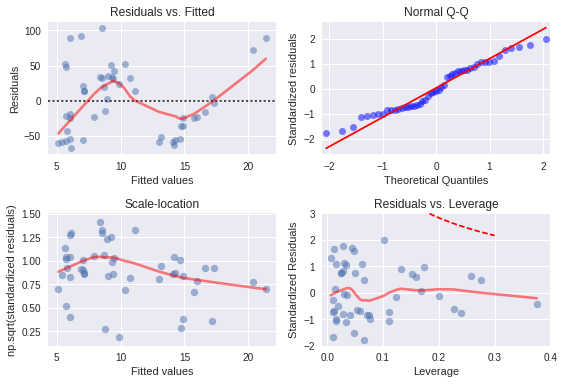

In [66]:
make_plots(data=education_data_noAK, y='Y', 
           result=education_res_noAK_weight,
           xmin=-0.01, xmax=0.4, ymin=-2, ymax=3)

The above two plots (1. Residuals vs. Fitted and 3.Scale-location) look way different from the plots from R. The other two plots (2. Normal Q-Q and 4. Residuals vs. Leverage) look similar enough (below image is obtained from R).  

The x-axis of the two plots (1. and 3.) looks off (5~20 magnitue in above vs. 200~300 magnitue in below).  

Let's try another attempt to replicate the two plots (1. Residuals vs. Fitted and 3.Scale-location)
<img src="img/plot_9_transformations_wls_from_R.png" width="600">

In [48]:
education_res_noAK_weight.fittedvalues[:5]

array([6.01521838, 7.04891132, 6.05022893, 7.92392671, 7.15675566])

In [49]:
education_res_noAK.fittedvalues[:5]

0    235.073537
1    267.657998
2    228.546716
3    302.160696
4    280.179747
dtype: float64

In [50]:
education_res_noAK.model.endog[:5]

array([235., 231., 270., 261., 300.])

Fittedvalues magnitdue looks off.. 

* attempt 2. using WLS itself  

In [51]:
education_res_noAK_weight2 = WLS(endog=education_data_noAK["Y"],
                                exog=sm.add_constant(education_data_noAK[["X1","X2","X3"]]),
                                weights=weights,
                                data=education_data_noAK).fit()
education_res_noAK_weight2.summary()

/home/doojung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.757
Model:                            WLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     46.75
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.10e-14
Time:                        01:10:27   Log-Likelihood:                -231.58
No. Observations:                  49   AIC:                             471.2
Df Residuals:                      45   BIC:                             478.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -315.5170     78.178     -4.036      0.000    -472.975    -158.059
X1             0.0623      0.008      7.916      0.000       0.046       0.078
X2             0.8743      0.200      4.366      0.000       0.471       1.278
X3             0.0294      0.034      0.857      0.396      -0.040       0.098
==============================================================================
Omnibus:                        6.395   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                2.405
Skew:                           0.147   Prob(JB):                        0.300
Kurtosis:                       1.955   Cond. No.                     1.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
# now it looks about right
education_res_noAK_weight2.fittedvalues[:5]

0    229.140571
1    268.517527
2    230.474244
3    301.849903
4    272.625692
dtype: float64

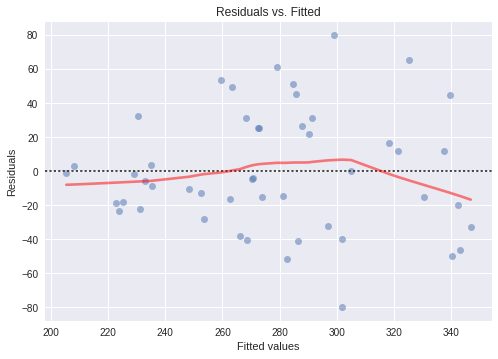

In [53]:
# Residual vs Fitted looks about right
sns.residplot(education_res_noAK_weight2.fittedvalues, 'Y', 
              data=education_data_noAK,
              lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

<img src='img/plot_9_transformations_wls_from_R.png'>

In [55]:
# the following line throws AttributeError because wls result does not have get_influence()
# norm_resid = education_res_noAK_weight2.get_influence().resid_studentized_internal

In [ ]:
# FAILED to replicate Scale-Location plots.
# TODO: try again later ...

Let's look at the boxplot again. It looks better, but perhaps not perfect.

In [89]:
education_data_noAK["resid_pearson"] = education_res_noAK_weight2.resid_pearson

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [90]:
education_data_noAK.head()

,STATE,Y,X1,X2,X3,Region,rstandard,resid_pearson
0,ME,235,3944,325,508,1,-0.002112,0.156067
1,NH,231,4578,323,564,1,-1.041857,-0.999289
2,VT,270,4011,328,322,1,1.255256,1.052778
3,MA,261,5233,305,846,1,-1.192622,-1.088047
4,RI,300,4780,303,871,1,0.594919,0.729121


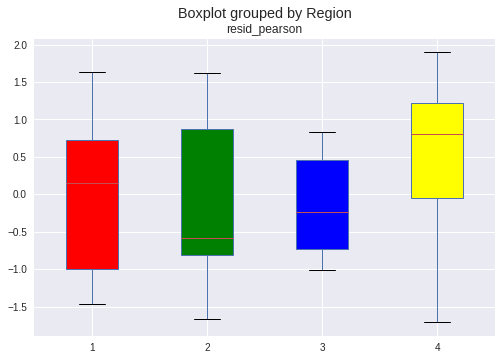

In [91]:
# to fill the colors inside the box
bp_dict = education_data_noAK.boxplot("resid_pearson",
    by="Region", 
    return_type='both',
    patch_artist = True,
)

colors = ['red', 'green', 'blue', 'yellow']
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.show()

## Unequal variance: effects on inference

-   So far, we have just mentioned that things *may* have unequal
    variance, but not thought about how it affects inference.

-   In general, if we ignore unequal variance, our estimates of variance
    are not very good. The covariance has the â€œsandwich formâ€ we saw above
    $$\text{Cov}(\widehat{\beta}_{OLS}) = (X'X)^{-1}(X'W^{-1}X)(X'X)^{-1}.$$
    with $W=\text{diag}(1/\sigma^2_i)$.
    
- ** If our `Std. Error` is incorrect, so are our conclusions based on $t$-statistics!**

- In this example, correcting for weights seemed to make the $t$-statistics larger. ** This will not always be the case!**

## Unequal variance: effects on inference

- Weighted least squares estimator
$$
\hat{\beta}_{WLS} = (X^TWX)^{-1}X^TWY
$$

-   If we have the correct weights, then
$$
\text{Cov}(\widehat{\beta}_{WLS}) = (X^TWX)^{-1}.
$$


## Efficiency

-   The efficiency of an unbiased estimator of $\beta$ is 1 / variance.

-   Estimators can be compared by their efficiency: the more efficient,
    the better.

-   The other reason to correct for unequal variance (besides so that we
    get valid inference) is for efficiency.

## Illustrative example

-   Suppose
    $$Z_i = \mu + \varepsilon_i, \qquad \varepsilon_i \sim N(0, i^2 \cdot \sigma^2), 1 \leq i \leq n.$$

-   Three unbiased estimators of $\mu$: $$\begin{aligned}
       \widehat{\mu}_1 &= \frac{1}{n}\sum_{i=1}^n Z_i \\
       \widehat{\mu}_2 &= \frac{1}{\sum_{i=1}^n i^{-2}}\sum_{i=1}^n i^{-2}Z_i \\
       \widehat{\mu}_3 &= \frac{1}{\sum_{i=1}^n i^{-1}}\sum_{i=1}^n i^{-1}Z_i \\
       \end{aligned}$$

## Illustrative example


-   The estimator $\widehat{\mu}_2$ will always have lower variance,
    hence tighter confidence intervals. 
    
- The estimator $\widehat{\mu}_3$ has incorrect weights, but they are "closer" to correct
than the naive mean's weights which assume each observation has equal variance.

Let's simulate a number of experiments and compare the three estimates.